In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
import keras.backend as K
from keras.layers import Conv1D, MaxPool1D, Dropout, UpSampling1D, Input, Flatten, Dense, LeakyReLU, GlobalAveragePooling1D
from keras.models import *
from keras import optimizers
from keras.layers.merge import concatenate
from keras.callbacks import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
def prepare_old_model(input_shape = (227, 1)):
    model = Sequential()

    model.add(Conv1D(16, 5, activation = 'relu', input_shape = input_shape))
    model.add(MaxPool1D(2, 2))
    model.add(Conv1D(32, 5, activation = 'relu'))
    model.add(MaxPool1D(2, 2))
    model.add(Conv1D(64, 5, activation = 'relu'))
    model.add(MaxPool1D(2, 2))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(9, activation='softmax'))
    return model

In [9]:
def prepare_nir_resnet_model(input_shape = (227, 1)):
    inpt = Input(input_shape)
    
    conv1 = Conv1D(8, 5, padding='same')(inpt)
    conv1 = LeakyReLU()(conv1)
    conv1 = concatenate([inpt, conv1], 2)
    conv1 = Conv1D(16, 5, padding='same')(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPool1D(2, 2)(conv1)
    
    conv2 = Conv1D(16, 5, padding='same')(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = concatenate([pool1, conv2], 2)
    conv2 = Conv1D(32, 5, padding='same')(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPool1D(2, 2)(conv2)
    
    conv3 = Conv1D(32, 5, padding='same')(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = concatenate([pool2, conv3], 2)
    conv3 = Conv1D(64, 5, padding='same')(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPool1D(2, 2)(conv3)
    
    flatt = Flatten()(pool3)
    dens0 = Dense(128)(flatt)
    dens0 = LeakyReLU()(dens0)
    drop0 = Dropout(0.5)(dens0)
    
    dens1 = Dense(256)(drop0)
    dens1 = LeakyReLU()(dens1)
    drop1 = Dropout(0.5)(dens1)
    outpt = Dense(9, activation='softmax')(drop1)
    
    return Model(inpt, outpt)

In [10]:
model = prepare_nir_resnet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 227, 1)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 227, 8)       48          input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 227, 8)       0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 227, 9)       0           input_2[0][0]                    
                                                                 leaky_re_lu_9[0][0]        

In [11]:
adam = optimizers.Adam(0.0001, 0.9, 0.99)
model.compile(adam, 'categorical_crossentropy', ['accuracy'])

In [12]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3, min_lr=0.0001)

In [13]:
temp = np.load('./Data/Training data/training_der.npz')
X_data = temp['xdata']
y_true = temp['ytrue']
y_hot = np.zeros((len(y_true), 9))
y_hot[np.arange(len(y_true)), y_true] = 1
X_train, X_test, y_train, y_test = train_test_split(X_data, y_hot)

In [14]:
history = model.fit(X_train, y_train, 128, 3000, 1, [reduce_lr], validation_data=(X_test, y_test))

Train on 1018 samples, validate on 340 samples
Epoch 1/3000
1018/1018 [==============================] - 1s 501us/step - loss: 2.1907 - accuracy: 0.1316 - val_loss: 2.1735 - val_accuracy: 0.3000
Epoch 2/3000
1018/1018 [==============================] - 0s 64us/step - loss: 2.1685 - accuracy: 0.1749 - val_loss: 2.1558 - val_accuracy: 0.2382
Epoch 3/3000
1018/1018 [==============================] - 0s 70us/step - loss: 2.1484 - accuracy: 0.1945 - val_loss: 2.1344 - val_accuracy: 0.2324
Epoch 4/3000
1018/1018 [==============================] - 0s 65us/step - loss: 2.1237 - accuracy: 0.1916 - val_loss: 2.1087 - val_accuracy: 0.1676
Epoch 5/3000
1018/1018 [==============================] - 0s 65us/step - loss: 2.1035 - accuracy: 0.1680 - val_loss: 2.0805 - val_accuracy: 0.1647
Epoch 6/3000
1018/1018 [==============================] - 0s 66us/step - loss: 2.0781 - accuracy: 0.2063 - val_loss: 2.0464 - val_accuracy: 0.2676
Epoch 7/3000
1018/1018 [==============================] - 0s 68us/step

1018/1018 [==============================] - 0s 63us/step - loss: 1.0814 - accuracy: 0.6287 - val_loss: 0.8471 - val_accuracy: 0.7265
Epoch 57/3000
1018/1018 [==============================] - 0s 68us/step - loss: 1.0398 - accuracy: 0.6297 - val_loss: 0.8164 - val_accuracy: 0.7676
Epoch 58/3000
1018/1018 [==============================] - 0s 58us/step - loss: 1.0430 - accuracy: 0.6424 - val_loss: 0.8043 - val_accuracy: 0.7412
Epoch 59/3000
1018/1018 [==============================] - 0s 62us/step - loss: 1.0593 - accuracy: 0.6159 - val_loss: 0.8033 - val_accuracy: 0.7559
Epoch 60/3000
1018/1018 [==============================] - 0s 61us/step - loss: 1.0438 - accuracy: 0.6405 - val_loss: 0.8036 - val_accuracy: 0.7324
Epoch 61/3000
1018/1018 [==============================] - 0s 75us/step - loss: 1.0323 - accuracy: 0.6385 - val_loss: 0.7857 - val_accuracy: 0.7618
Epoch 62/3000
1018/1018 [==============================] - 0s 61us/step - loss: 1.0391 - accuracy: 0.6365 - val_loss: 0.8107 -

1018/1018 [==============================] - 0s 64us/step - loss: 0.6677 - accuracy: 0.7554 - val_loss: 0.4710 - val_accuracy: 0.8412
Epoch 112/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.6953 - accuracy: 0.7682 - val_loss: 0.4670 - val_accuracy: 0.8529
Epoch 113/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.6384 - accuracy: 0.7927 - val_loss: 0.4496 - val_accuracy: 0.8765
Epoch 114/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.6480 - accuracy: 0.7947 - val_loss: 0.4518 - val_accuracy: 0.8647
Epoch 115/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.6552 - accuracy: 0.7741 - val_loss: 0.4543 - val_accuracy: 0.8794
Epoch 116/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.6359 - accuracy: 0.7868 - val_loss: 0.4540 - val_accuracy: 0.8794
Epoch 117/3000
1018/1018 [==============================] - 0s 68us/step - loss: 0.6846 - accuracy: 0.7652 - val_loss: 0.

1018/1018 [==============================] - 0s 63us/step - loss: 0.4641 - accuracy: 0.8330 - val_loss: 0.3115 - val_accuracy: 0.9147
Epoch 167/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.4550 - accuracy: 0.8399 - val_loss: 0.3118 - val_accuracy: 0.9029
Epoch 168/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.4797 - accuracy: 0.8251 - val_loss: 0.3054 - val_accuracy: 0.9176
Epoch 169/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.4528 - accuracy: 0.8438 - val_loss: 0.3017 - val_accuracy: 0.9176
Epoch 170/3000
1018/1018 [==============================] - 0s 78us/step - loss: 0.4692 - accuracy: 0.8379 - val_loss: 0.3138 - val_accuracy: 0.9059
Epoch 171/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.4456 - accuracy: 0.8389 - val_loss: 0.3209 - val_accuracy: 0.8941
Epoch 172/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.4723 - accuracy: 0.8487 - val_loss: 0.

1018/1018 [==============================] - 0s 53us/step - loss: 0.3822 - accuracy: 0.8674 - val_loss: 0.2499 - val_accuracy: 0.9294
Epoch 222/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.3899 - accuracy: 0.8654 - val_loss: 0.2414 - val_accuracy: 0.9265
Epoch 223/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.3908 - accuracy: 0.8576 - val_loss: 0.2570 - val_accuracy: 0.9118
Epoch 224/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.3871 - accuracy: 0.8625 - val_loss: 0.2482 - val_accuracy: 0.9235
Epoch 225/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.3766 - accuracy: 0.8585 - val_loss: 0.2384 - val_accuracy: 0.9235
Epoch 226/3000
1018/1018 [==============================] - 0s 52us/step - loss: 0.3556 - accuracy: 0.8851 - val_loss: 0.2413 - val_accuracy: 0.9235
Epoch 227/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.3785 - accuracy: 0.8713 - val_loss: 0.

1018/1018 [==============================] - 0s 74us/step - loss: 0.3127 - accuracy: 0.8978 - val_loss: 0.2136 - val_accuracy: 0.9294
Epoch 277/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.3186 - accuracy: 0.8861 - val_loss: 0.2090 - val_accuracy: 0.9412
Epoch 278/3000
1018/1018 [==============================] - 0s 87us/step - loss: 0.3209 - accuracy: 0.8811 - val_loss: 0.2157 - val_accuracy: 0.9206
Epoch 279/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.3379 - accuracy: 0.8910 - val_loss: 0.2086 - val_accuracy: 0.9353
Epoch 280/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.3046 - accuracy: 0.8900 - val_loss: 0.2704 - val_accuracy: 0.9000
Epoch 281/3000
1018/1018 [==============================] - 0s 68us/step - loss: 0.3386 - accuracy: 0.8792 - val_loss: 0.2515 - val_accuracy: 0.9265
Epoch 282/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.3510 - accuracy: 0.8821 - val_loss: 0.

1018/1018 [==============================] - 0s 63us/step - loss: 0.2772 - accuracy: 0.9037 - val_loss: 0.2089 - val_accuracy: 0.9324
Epoch 332/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.2690 - accuracy: 0.9106 - val_loss: 0.1966 - val_accuracy: 0.9353
Epoch 333/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.2650 - accuracy: 0.9096 - val_loss: 0.2111 - val_accuracy: 0.9382
Epoch 334/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.2659 - accuracy: 0.9057 - val_loss: 0.1988 - val_accuracy: 0.9382
Epoch 335/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.2740 - accuracy: 0.9077 - val_loss: 0.1896 - val_accuracy: 0.9324
Epoch 336/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.2725 - accuracy: 0.9175 - val_loss: 0.2022 - val_accuracy: 0.9353
Epoch 337/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.2835 - accuracy: 0.8890 - val_loss: 0.

1018/1018 [==============================] - 0s 54us/step - loss: 0.2646 - accuracy: 0.9067 - val_loss: 0.2046 - val_accuracy: 0.9324
Epoch 387/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.2759 - accuracy: 0.9116 - val_loss: 0.2018 - val_accuracy: 0.9206
Epoch 388/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.2495 - accuracy: 0.9086 - val_loss: 0.1876 - val_accuracy: 0.9382
Epoch 389/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.2589 - accuracy: 0.9028 - val_loss: 0.2028 - val_accuracy: 0.9324
Epoch 390/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.2434 - accuracy: 0.9136 - val_loss: 0.1803 - val_accuracy: 0.9412
Epoch 391/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.2487 - accuracy: 0.9086 - val_loss: 0.1897 - val_accuracy: 0.9382
Epoch 392/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.2356 - accuracy: 0.9136 - val_loss: 0.

1018/1018 [==============================] - 0s 59us/step - loss: 0.2304 - accuracy: 0.9204 - val_loss: 0.1705 - val_accuracy: 0.9294
Epoch 442/3000
1018/1018 [==============================] - 0s 52us/step - loss: 0.2262 - accuracy: 0.9263 - val_loss: 0.1706 - val_accuracy: 0.9471
Epoch 443/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.2466 - accuracy: 0.9126 - val_loss: 0.1851 - val_accuracy: 0.9412
Epoch 444/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.2429 - accuracy: 0.9234 - val_loss: 0.1882 - val_accuracy: 0.9235
Epoch 445/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.2311 - accuracy: 0.9224 - val_loss: 0.1899 - val_accuracy: 0.9382
Epoch 446/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.2166 - accuracy: 0.9234 - val_loss: 0.1667 - val_accuracy: 0.9471
Epoch 447/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.2178 - accuracy: 0.9194 - val_loss: 0.

1018/1018 [==============================] - 0s 61us/step - loss: 0.1982 - accuracy: 0.9204 - val_loss: 0.1689 - val_accuracy: 0.9529
Epoch 497/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.2024 - accuracy: 0.9283 - val_loss: 0.1594 - val_accuracy: 0.9471
Epoch 498/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.2106 - accuracy: 0.9204 - val_loss: 0.1892 - val_accuracy: 0.9265
Epoch 499/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.1885 - accuracy: 0.9420 - val_loss: 0.1606 - val_accuracy: 0.9471
Epoch 500/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.1882 - accuracy: 0.9381 - val_loss: 0.1664 - val_accuracy: 0.9441
Epoch 501/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.1855 - accuracy: 0.9332 - val_loss: 0.1625 - val_accuracy: 0.9471
Epoch 502/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.2085 - accuracy: 0.9253 - val_loss: 0.

1018/1018 [==============================] - 0s 58us/step - loss: 0.1731 - accuracy: 0.9401 - val_loss: 0.1677 - val_accuracy: 0.9441
Epoch 552/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.1812 - accuracy: 0.9322 - val_loss: 0.1644 - val_accuracy: 0.9382
Epoch 553/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.1777 - accuracy: 0.9391 - val_loss: 0.1626 - val_accuracy: 0.9441
Epoch 554/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.1939 - accuracy: 0.9293 - val_loss: 0.2032 - val_accuracy: 0.9353
Epoch 555/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.2006 - accuracy: 0.9283 - val_loss: 0.1991 - val_accuracy: 0.9265
Epoch 556/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.1856 - accuracy: 0.9332 - val_loss: 0.1564 - val_accuracy: 0.9471
Epoch 557/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.1765 - accuracy: 0.9381 - val_loss: 0.

1018/1018 [==============================] - 0s 70us/step - loss: 0.1395 - accuracy: 0.9587 - val_loss: 0.1540 - val_accuracy: 0.9471
Epoch 607/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.1526 - accuracy: 0.9420 - val_loss: 0.1615 - val_accuracy: 0.9441
Epoch 608/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.1610 - accuracy: 0.9401 - val_loss: 0.1604 - val_accuracy: 0.9382
Epoch 609/3000
1018/1018 [==============================] - 0s 75us/step - loss: 0.1533 - accuracy: 0.9420 - val_loss: 0.1599 - val_accuracy: 0.9500
Epoch 610/3000
1018/1018 [==============================] - 0s 80us/step - loss: 0.1681 - accuracy: 0.9322 - val_loss: 0.2021 - val_accuracy: 0.9235
Epoch 611/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.1493 - accuracy: 0.9391 - val_loss: 0.1588 - val_accuracy: 0.9441
Epoch 612/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.1777 - accuracy: 0.9322 - val_loss: 0.

1018/1018 [==============================] - 0s 64us/step - loss: 0.1349 - accuracy: 0.9528 - val_loss: 0.1568 - val_accuracy: 0.9529
Epoch 662/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.1320 - accuracy: 0.9509 - val_loss: 0.1503 - val_accuracy: 0.9647
Epoch 663/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.1234 - accuracy: 0.9558 - val_loss: 0.1690 - val_accuracy: 0.9500
Epoch 664/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.1212 - accuracy: 0.9509 - val_loss: 0.1550 - val_accuracy: 0.9500
Epoch 665/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.1392 - accuracy: 0.9479 - val_loss: 0.1513 - val_accuracy: 0.9647
Epoch 666/3000
1018/1018 [==============================] - 0s 86us/step - loss: 0.1297 - accuracy: 0.9519 - val_loss: 0.1663 - val_accuracy: 0.9382
Epoch 667/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.1614 - accuracy: 0.9371 - val_loss: 0.

1018/1018 [==============================] - 0s 64us/step - loss: 0.1356 - accuracy: 0.9509 - val_loss: 0.1574 - val_accuracy: 0.9500
Epoch 717/3000
1018/1018 [==============================] - 0s 72us/step - loss: 0.1177 - accuracy: 0.9528 - val_loss: 0.1752 - val_accuracy: 0.9382
Epoch 718/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.1224 - accuracy: 0.9479 - val_loss: 0.1533 - val_accuracy: 0.9647
Epoch 719/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.1663 - accuracy: 0.9312 - val_loss: 0.1735 - val_accuracy: 0.9471
Epoch 720/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.1259 - accuracy: 0.9578 - val_loss: 0.1651 - val_accuracy: 0.9500
Epoch 721/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.1168 - accuracy: 0.9538 - val_loss: 0.1456 - val_accuracy: 0.9529
Epoch 722/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.1233 - accuracy: 0.9558 - val_loss: 0.

1018/1018 [==============================] - 0s 54us/step - loss: 0.0995 - accuracy: 0.9656 - val_loss: 0.1631 - val_accuracy: 0.9500
Epoch 772/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0906 - accuracy: 0.9676 - val_loss: 0.1515 - val_accuracy: 0.9529
Epoch 773/3000
1018/1018 [==============================] - 0s 78us/step - loss: 0.0981 - accuracy: 0.9686 - val_loss: 0.1698 - val_accuracy: 0.9471
Epoch 774/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0993 - accuracy: 0.9646 - val_loss: 0.1454 - val_accuracy: 0.9529
Epoch 775/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0971 - accuracy: 0.9656 - val_loss: 0.1525 - val_accuracy: 0.9559
Epoch 776/3000
1018/1018 [==============================] - 0s 82us/step - loss: 0.0914 - accuracy: 0.9695 - val_loss: 0.1389 - val_accuracy: 0.9588
Epoch 777/3000
1018/1018 [==============================] - 0s 77us/step - loss: 0.0876 - accuracy: 0.9686 - val_loss: 0.

1018/1018 [==============================] - 0s 68us/step - loss: 0.0879 - accuracy: 0.9735 - val_loss: 0.1471 - val_accuracy: 0.9559
Epoch 827/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.1005 - accuracy: 0.9568 - val_loss: 0.1637 - val_accuracy: 0.9529
Epoch 828/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0977 - accuracy: 0.9637 - val_loss: 0.1606 - val_accuracy: 0.9588
Epoch 829/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.1005 - accuracy: 0.9656 - val_loss: 0.1556 - val_accuracy: 0.9529
Epoch 830/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0930 - accuracy: 0.9705 - val_loss: 0.1690 - val_accuracy: 0.9559
Epoch 831/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.1029 - accuracy: 0.9607 - val_loss: 0.1489 - val_accuracy: 0.9529
Epoch 832/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0978 - accuracy: 0.9597 - val_loss: 0.

1018/1018 [==============================] - 0s 56us/step - loss: 0.0897 - accuracy: 0.9676 - val_loss: 0.1535 - val_accuracy: 0.9559
Epoch 882/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0868 - accuracy: 0.9656 - val_loss: 0.1521 - val_accuracy: 0.9529
Epoch 883/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0845 - accuracy: 0.9705 - val_loss: 0.1664 - val_accuracy: 0.9559
Epoch 884/3000
1018/1018 [==============================] - 0s 87us/step - loss: 0.1009 - accuracy: 0.9548 - val_loss: 0.1484 - val_accuracy: 0.9559
Epoch 885/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0923 - accuracy: 0.9666 - val_loss: 0.1548 - val_accuracy: 0.9559
Epoch 886/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0779 - accuracy: 0.9735 - val_loss: 0.1511 - val_accuracy: 0.9618
Epoch 887/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0875 - accuracy: 0.9725 - val_loss: 0.

1018/1018 [==============================] - 0s 62us/step - loss: 0.0835 - accuracy: 0.9686 - val_loss: 0.1712 - val_accuracy: 0.9500
Epoch 937/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0840 - accuracy: 0.9715 - val_loss: 0.1483 - val_accuracy: 0.9618
Epoch 938/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0783 - accuracy: 0.9666 - val_loss: 0.1513 - val_accuracy: 0.9559
Epoch 939/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0823 - accuracy: 0.9676 - val_loss: 0.1606 - val_accuracy: 0.9618
Epoch 940/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0728 - accuracy: 0.9754 - val_loss: 0.1531 - val_accuracy: 0.9559
Epoch 941/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0691 - accuracy: 0.9735 - val_loss: 0.1956 - val_accuracy: 0.9412
Epoch 942/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0784 - accuracy: 0.9735 - val_loss: 0.

1018/1018 [==============================] - 0s 54us/step - loss: 0.0743 - accuracy: 0.9686 - val_loss: 0.1574 - val_accuracy: 0.9500
Epoch 992/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0833 - accuracy: 0.9764 - val_loss: 0.2230 - val_accuracy: 0.9412
Epoch 993/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0650 - accuracy: 0.9794 - val_loss: 0.1547 - val_accuracy: 0.9647
Epoch 994/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0736 - accuracy: 0.9754 - val_loss: 0.1607 - val_accuracy: 0.9588
Epoch 995/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0701 - accuracy: 0.9774 - val_loss: 0.1614 - val_accuracy: 0.9676
Epoch 996/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0647 - accuracy: 0.9774 - val_loss: 0.1507 - val_accuracy: 0.9559
Epoch 997/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.0680 - accuracy: 0.9794 - val_loss: 0.

Epoch 1046/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0478 - accuracy: 0.9813 - val_loss: 0.1627 - val_accuracy: 0.9559
Epoch 1047/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.0544 - accuracy: 0.9804 - val_loss: 0.1581 - val_accuracy: 0.9618
Epoch 1048/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0549 - accuracy: 0.9843 - val_loss: 0.1695 - val_accuracy: 0.9588
Epoch 1049/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0586 - accuracy: 0.9823 - val_loss: 0.1571 - val_accuracy: 0.9618
Epoch 1050/3000
1018/1018 [==============================] - 0s 83us/step - loss: 0.0595 - accuracy: 0.9774 - val_loss: 0.1598 - val_accuracy: 0.9676
Epoch 1051/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0465 - accuracy: 0.9853 - val_loss: 0.1587 - val_accuracy: 0.9529
Epoch 1052/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0653 - accuracy:

1018/1018 [==============================] - 0s 65us/step - loss: 0.0606 - accuracy: 0.9764 - val_loss: 0.1725 - val_accuracy: 0.9618
Epoch 1101/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0674 - accuracy: 0.9745 - val_loss: 0.1670 - val_accuracy: 0.9529
Epoch 1102/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0570 - accuracy: 0.9794 - val_loss: 0.1876 - val_accuracy: 0.9441
Epoch 1103/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0676 - accuracy: 0.9774 - val_loss: 0.1739 - val_accuracy: 0.9618
Epoch 1104/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0827 - accuracy: 0.9656 - val_loss: 0.1820 - val_accuracy: 0.9500
Epoch 1105/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0692 - accuracy: 0.9735 - val_loss: 0.1618 - val_accuracy: 0.9647
Epoch 1106/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0611 - accuracy: 0.9784 - val_lo

Epoch 1155/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0382 - accuracy: 0.9882 - val_loss: 0.1780 - val_accuracy: 0.9588
Epoch 1156/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0406 - accuracy: 0.9882 - val_loss: 0.1697 - val_accuracy: 0.9588
Epoch 1157/3000
1018/1018 [==============================] - 0s 72us/step - loss: 0.0483 - accuracy: 0.9813 - val_loss: 0.1794 - val_accuracy: 0.9647
Epoch 1158/3000
1018/1018 [==============================] - 0s 76us/step - loss: 0.0474 - accuracy: 0.9833 - val_loss: 0.1641 - val_accuracy: 0.9647
Epoch 1159/3000
1018/1018 [==============================] - 0s 71us/step - loss: 0.0457 - accuracy: 0.9823 - val_loss: 0.1675 - val_accuracy: 0.9559
Epoch 1160/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0528 - accuracy: 0.9804 - val_loss: 0.1835 - val_accuracy: 0.9529
Epoch 1161/3000
1018/1018 [==============================] - 0s 84us/step - loss: 0.0646 - accuracy:

1018/1018 [==============================] - 0s 60us/step - loss: 0.0647 - accuracy: 0.9754 - val_loss: 0.1488 - val_accuracy: 0.9676
Epoch 1210/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0420 - accuracy: 0.9853 - val_loss: 0.1793 - val_accuracy: 0.9559
Epoch 1211/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0445 - accuracy: 0.9872 - val_loss: 0.1667 - val_accuracy: 0.9618
Epoch 1212/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0377 - accuracy: 0.9843 - val_loss: 0.1899 - val_accuracy: 0.9588
Epoch 1213/3000
1018/1018 [==============================] - 0s 72us/step - loss: 0.0313 - accuracy: 0.9912 - val_loss: 0.1775 - val_accuracy: 0.9588
Epoch 1214/3000
1018/1018 [==============================] - 0s 71us/step - loss: 0.0402 - accuracy: 0.9853 - val_loss: 0.1751 - val_accuracy: 0.9618
Epoch 1215/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0554 - accuracy: 0.9833 - val_lo

Epoch 1264/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0479 - accuracy: 0.9872 - val_loss: 0.1838 - val_accuracy: 0.9618
Epoch 1265/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0443 - accuracy: 0.9784 - val_loss: 0.1750 - val_accuracy: 0.9618
Epoch 1266/3000
1018/1018 [==============================] - 0s 89us/step - loss: 0.0468 - accuracy: 0.9813 - val_loss: 0.1684 - val_accuracy: 0.9647
Epoch 1267/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0749 - accuracy: 0.9764 - val_loss: 0.1989 - val_accuracy: 0.9588
Epoch 1268/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0614 - accuracy: 0.9794 - val_loss: 0.1745 - val_accuracy: 0.9588
Epoch 1269/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0692 - accuracy: 0.9715 - val_loss: 0.2441 - val_accuracy: 0.9382
Epoch 1270/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0413 - accuracy:

1018/1018 [==============================] - 0s 58us/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 0.1606 - val_accuracy: 0.9676
Epoch 1319/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0281 - accuracy: 0.9892 - val_loss: 0.1707 - val_accuracy: 0.9647
Epoch 1320/3000
1018/1018 [==============================] - 0s 82us/step - loss: 0.0343 - accuracy: 0.9872 - val_loss: 0.1896 - val_accuracy: 0.9588
Epoch 1321/3000
1018/1018 [==============================] - 0s 83us/step - loss: 0.0256 - accuracy: 0.9912 - val_loss: 0.1626 - val_accuracy: 0.9588
Epoch 1322/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0381 - accuracy: 0.9892 - val_loss: 0.1611 - val_accuracy: 0.9647
Epoch 1323/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0428 - accuracy: 0.9862 - val_loss: 0.1857 - val_accuracy: 0.9588
Epoch 1324/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0426 - accuracy: 0.9853 - val_lo

Epoch 1373/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0681 - accuracy: 0.9725 - val_loss: 0.2296 - val_accuracy: 0.9382
Epoch 1374/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0524 - accuracy: 0.9745 - val_loss: 0.1715 - val_accuracy: 0.9618
Epoch 1375/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0294 - accuracy: 0.9902 - val_loss: 0.1730 - val_accuracy: 0.9618
Epoch 1376/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0328 - accuracy: 0.9912 - val_loss: 0.1986 - val_accuracy: 0.9529
Epoch 1377/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0317 - accuracy: 0.9862 - val_loss: 0.1856 - val_accuracy: 0.9529
Epoch 1378/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0414 - accuracy: 0.9833 - val_loss: 0.1803 - val_accuracy: 0.9647
Epoch 1379/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0387 - accuracy:

1018/1018 [==============================] - 0s 59us/step - loss: 0.0322 - accuracy: 0.9941 - val_loss: 0.1788 - val_accuracy: 0.9559
Epoch 1428/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0354 - accuracy: 0.9912 - val_loss: 0.1856 - val_accuracy: 0.9618
Epoch 1429/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0308 - accuracy: 0.9912 - val_loss: 0.2224 - val_accuracy: 0.9500
Epoch 1430/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0333 - accuracy: 0.9872 - val_loss: 0.1880 - val_accuracy: 0.9588
Epoch 1431/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0338 - accuracy: 0.9892 - val_loss: 0.2041 - val_accuracy: 0.9588
Epoch 1432/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.1808 - val_accuracy: 0.9559
Epoch 1433/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0326 - accuracy: 0.9892 - val_lo

Epoch 1482/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0258 - accuracy: 0.9912 - val_loss: 0.1867 - val_accuracy: 0.9529
Epoch 1483/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0208 - accuracy: 0.9921 - val_loss: 0.1886 - val_accuracy: 0.9618
Epoch 1484/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0211 - accuracy: 0.9912 - val_loss: 0.1927 - val_accuracy: 0.9647
Epoch 1485/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.2068 - val_accuracy: 0.9559
Epoch 1486/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0228 - accuracy: 0.9941 - val_loss: 0.1854 - val_accuracy: 0.9647
Epoch 1487/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0253 - accuracy: 0.9931 - val_loss: 0.1926 - val_accuracy: 0.9647
Epoch 1488/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0237 - accuracy:

1018/1018 [==============================] - 0s 77us/step - loss: 0.0417 - accuracy: 0.9882 - val_loss: 0.2095 - val_accuracy: 0.9559
Epoch 1537/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.1917 - val_accuracy: 0.9588
Epoch 1538/3000
1018/1018 [==============================] - 0s 78us/step - loss: 0.0281 - accuracy: 0.9902 - val_loss: 0.2030 - val_accuracy: 0.9559
Epoch 1539/3000
1018/1018 [==============================] - 0s 96us/step - loss: 0.0216 - accuracy: 0.9941 - val_loss: 0.2305 - val_accuracy: 0.9412
Epoch 1540/3000
1018/1018 [==============================] - 0s 79us/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.2130 - val_accuracy: 0.9588
Epoch 1541/3000
1018/1018 [==============================] - 0s 77us/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.2011 - val_accuracy: 0.9588
Epoch 1542/3000
1018/1018 [==============================] - 0s 84us/step - loss: 0.0203 - accuracy: 0.9931 - val_lo

Epoch 1591/3000
1018/1018 [==============================] - 0s 51us/step - loss: 0.0221 - accuracy: 0.9921 - val_loss: 0.1985 - val_accuracy: 0.9618
Epoch 1592/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0321 - accuracy: 0.9862 - val_loss: 0.1921 - val_accuracy: 0.9559
Epoch 1593/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0148 - accuracy: 0.9951 - val_loss: 0.1904 - val_accuracy: 0.9618
Epoch 1594/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.1850 - val_accuracy: 0.9559
Epoch 1595/3000
1018/1018 [==============================] - 0s 53us/step - loss: 0.0169 - accuracy: 0.9961 - val_loss: 0.1803 - val_accuracy: 0.9647
Epoch 1596/3000
1018/1018 [==============================] - 0s 71us/step - loss: 0.0288 - accuracy: 0.9902 - val_loss: 0.1814 - val_accuracy: 0.9647
Epoch 1597/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0284 - accuracy:

1018/1018 [==============================] - 0s 55us/step - loss: 0.0243 - accuracy: 0.9912 - val_loss: 0.1870 - val_accuracy: 0.9529
Epoch 1646/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0272 - accuracy: 0.9921 - val_loss: 0.2398 - val_accuracy: 0.9471
Epoch 1647/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0294 - accuracy: 0.9882 - val_loss: 0.2260 - val_accuracy: 0.9529
Epoch 1648/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.2009 - val_accuracy: 0.9618
Epoch 1649/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0242 - accuracy: 0.9912 - val_loss: 0.2101 - val_accuracy: 0.9618
Epoch 1650/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.1915 - val_accuracy: 0.9618
Epoch 1651/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0287 - accuracy: 0.9872 - val_lo

Epoch 1700/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0278 - accuracy: 0.9902 - val_loss: 0.1921 - val_accuracy: 0.9471
Epoch 1701/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.1817 - val_accuracy: 0.9529
Epoch 1702/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0334 - accuracy: 0.9912 - val_loss: 0.2031 - val_accuracy: 0.9588
Epoch 1703/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0290 - accuracy: 0.9892 - val_loss: 0.2397 - val_accuracy: 0.9353
Epoch 1704/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0359 - accuracy: 0.9843 - val_loss: 0.1807 - val_accuracy: 0.9588
Epoch 1705/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0347 - accuracy: 0.9843 - val_loss: 0.1937 - val_accuracy: 0.9559
Epoch 1706/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0266 - accuracy:

1018/1018 [==============================] - 0s 70us/step - loss: 0.0291 - accuracy: 0.9862 - val_loss: 0.2127 - val_accuracy: 0.9529
Epoch 1755/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.2016 - val_accuracy: 0.9471
Epoch 1756/3000
1018/1018 [==============================] - 0s 72us/step - loss: 0.0231 - accuracy: 0.9921 - val_loss: 0.2696 - val_accuracy: 0.9324
Epoch 1757/3000
1018/1018 [==============================] - 0s 68us/step - loss: 0.0272 - accuracy: 0.9892 - val_loss: 0.1953 - val_accuracy: 0.9500
Epoch 1758/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0224 - accuracy: 0.9921 - val_loss: 0.1999 - val_accuracy: 0.9588
Epoch 1759/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0244 - accuracy: 0.9921 - val_loss: 0.1963 - val_accuracy: 0.9588
Epoch 1760/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0176 - accuracy: 0.9971 - val_lo

Epoch 1809/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.2059 - val_accuracy: 0.9529
Epoch 1810/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0227 - accuracy: 0.9902 - val_loss: 0.2159 - val_accuracy: 0.9559
Epoch 1811/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0258 - accuracy: 0.9921 - val_loss: 0.1973 - val_accuracy: 0.9559
Epoch 1812/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.2181 - val_accuracy: 0.9471
Epoch 1813/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.1862 - val_accuracy: 0.9618
Epoch 1814/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.1921 - val_accuracy: 0.9588
Epoch 1815/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0160 - accuracy:

1018/1018 [==============================] - 0s 55us/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.2074 - val_accuracy: 0.9529
Epoch 1864/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.2037 - val_accuracy: 0.9559
Epoch 1865/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0174 - accuracy: 0.9921 - val_loss: 0.1892 - val_accuracy: 0.9588
Epoch 1866/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0215 - accuracy: 0.9921 - val_loss: 0.2111 - val_accuracy: 0.9559
Epoch 1867/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.1974 - val_accuracy: 0.9588
Epoch 1868/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0272 - accuracy: 0.9912 - val_loss: 0.2042 - val_accuracy: 0.9559
Epoch 1869/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0186 - accuracy: 0.9921 - val_lo

Epoch 1918/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.2102 - val_accuracy: 0.9588
Epoch 1919/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0259 - accuracy: 0.9912 - val_loss: 0.2330 - val_accuracy: 0.9441
Epoch 1920/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.2642 - val_accuracy: 0.9412
Epoch 1921/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0343 - accuracy: 0.9882 - val_loss: 0.1980 - val_accuracy: 0.9647
Epoch 1922/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0343 - accuracy: 0.9843 - val_loss: 0.2357 - val_accuracy: 0.9441
Epoch 1923/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0292 - accuracy: 0.9872 - val_loss: 0.2474 - val_accuracy: 0.9500
Epoch 1924/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0264 - accuracy:

1018/1018 [==============================] - 0s 62us/step - loss: 0.0138 - accuracy: 0.9951 - val_loss: 0.1971 - val_accuracy: 0.9559
Epoch 1973/3000
1018/1018 [==============================] - 0s 51us/step - loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.2193 - val_accuracy: 0.9471
Epoch 1974/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.2169 - val_accuracy: 0.9471
Epoch 1975/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0236 - accuracy: 0.9892 - val_loss: 0.2501 - val_accuracy: 0.9529
Epoch 1976/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0392 - accuracy: 0.9833 - val_loss: 0.2812 - val_accuracy: 0.9353
Epoch 1977/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0352 - accuracy: 0.9853 - val_loss: 0.2152 - val_accuracy: 0.9559
Epoch 1978/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0249 - accuracy: 0.9902 - val_lo

Epoch 2027/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 0.2066 - val_accuracy: 0.9559
Epoch 2028/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0178 - accuracy: 0.9931 - val_loss: 0.2161 - val_accuracy: 0.9588
Epoch 2029/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0238 - accuracy: 0.9921 - val_loss: 0.1969 - val_accuracy: 0.9647
Epoch 2030/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0257 - accuracy: 0.9882 - val_loss: 0.2236 - val_accuracy: 0.9441
Epoch 2031/3000
1018/1018 [==============================] - 0s 75us/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.2142 - val_accuracy: 0.9618
Epoch 2032/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0227 - accuracy: 0.9912 - val_loss: 0.2280 - val_accuracy: 0.9618
Epoch 2033/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0185 - accuracy:

1018/1018 [==============================] - 0s 88us/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 0.2389 - val_accuracy: 0.9529
Epoch 2082/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0147 - accuracy: 0.9941 - val_loss: 0.2286 - val_accuracy: 0.9529
Epoch 2083/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0255 - accuracy: 0.9902 - val_loss: 0.2399 - val_accuracy: 0.9500
Epoch 2084/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0150 - accuracy: 0.9941 - val_loss: 0.2020 - val_accuracy: 0.9529
Epoch 2085/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0154 - accuracy: 0.9931 - val_loss: 0.2126 - val_accuracy: 0.9500
Epoch 2086/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0129 - accuracy: 0.9971 - val_loss: 0.1934 - val_accuracy: 0.9529
Epoch 2087/3000
1018/1018 [==============================] - 0s 76us/step - loss: 0.0089 - accuracy: 0.9971 - val_lo

Epoch 2136/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.2371 - val_accuracy: 0.9588
Epoch 2137/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0222 - accuracy: 0.9931 - val_loss: 0.2501 - val_accuracy: 0.9500
Epoch 2138/3000
1018/1018 [==============================] - 0s 75us/step - loss: 0.0135 - accuracy: 0.9921 - val_loss: 0.2604 - val_accuracy: 0.9353
Epoch 2139/3000
1018/1018 [==============================] - 0s 77us/step - loss: 0.0206 - accuracy: 0.9882 - val_loss: 0.2915 - val_accuracy: 0.9441
Epoch 2140/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0228 - accuracy: 0.9912 - val_loss: 0.3281 - val_accuracy: 0.9235
Epoch 2141/3000
1018/1018 [==============================] - 0s 76us/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.2295 - val_accuracy: 0.9559
Epoch 2142/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0180 - accuracy:

1018/1018 [==============================] - 0s 57us/step - loss: 0.0114 - accuracy: 0.9971 - val_loss: 0.2474 - val_accuracy: 0.9500
Epoch 2191/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.2233 - val_accuracy: 0.9529
Epoch 2192/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.2164 - val_accuracy: 0.9559
Epoch 2193/3000
1018/1018 [==============================] - 0s 86us/step - loss: 0.0189 - accuracy: 0.9931 - val_loss: 0.2102 - val_accuracy: 0.9529
Epoch 2194/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.2249 - val_accuracy: 0.9500
Epoch 2195/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0224 - accuracy: 0.9892 - val_loss: 0.2451 - val_accuracy: 0.9500
Epoch 2196/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0185 - accuracy: 0.9941 - val_lo

Epoch 2245/3000
1018/1018 [==============================] - 0s 68us/step - loss: 0.0154 - accuracy: 0.9951 - val_loss: 0.2486 - val_accuracy: 0.9412
Epoch 2246/3000
1018/1018 [==============================] - 0s 75us/step - loss: 0.0178 - accuracy: 0.9892 - val_loss: 0.2213 - val_accuracy: 0.9588
Epoch 2247/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0247 - accuracy: 0.9902 - val_loss: 0.2263 - val_accuracy: 0.9588
Epoch 2248/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0130 - accuracy: 0.9941 - val_loss: 0.2347 - val_accuracy: 0.9529
Epoch 2249/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.2433 - val_accuracy: 0.9529
Epoch 2250/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.2378 - val_accuracy: 0.9441
Epoch 2251/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0121 - accuracy:

1018/1018 [==============================] - 0s 68us/step - loss: 0.0155 - accuracy: 0.9931 - val_loss: 0.2820 - val_accuracy: 0.9353
Epoch 2300/3000
1018/1018 [==============================] - 0s 81us/step - loss: 0.0165 - accuracy: 0.9921 - val_loss: 0.2047 - val_accuracy: 0.9559
Epoch 2301/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0127 - accuracy: 0.9951 - val_loss: 0.2337 - val_accuracy: 0.9471
Epoch 2302/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0140 - accuracy: 0.9961 - val_loss: 0.2461 - val_accuracy: 0.9529
Epoch 2303/3000
1018/1018 [==============================] - 0s 60us/step - loss: 0.0162 - accuracy: 0.9941 - val_loss: 0.2160 - val_accuracy: 0.9588
Epoch 2304/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.2402 - val_accuracy: 0.9500
Epoch 2305/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0161 - accuracy: 0.9941 - val_lo

Epoch 2354/3000
1018/1018 [==============================] - 0s 76us/step - loss: 0.0201 - accuracy: 0.9921 - val_loss: 0.2345 - val_accuracy: 0.9500
Epoch 2355/3000
1018/1018 [==============================] - 0s 68us/step - loss: 0.0160 - accuracy: 0.9941 - val_loss: 0.2957 - val_accuracy: 0.9441
Epoch 2356/3000
1018/1018 [==============================] - 0s 73us/step - loss: 0.0176 - accuracy: 0.9921 - val_loss: 0.2711 - val_accuracy: 0.9500
Epoch 2357/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0160 - accuracy: 0.9941 - val_loss: 0.2151 - val_accuracy: 0.9529
Epoch 2358/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0209 - accuracy: 0.9921 - val_loss: 0.2946 - val_accuracy: 0.9441
Epoch 2359/3000
1018/1018 [==============================] - 0s 76us/step - loss: 0.0166 - accuracy: 0.9941 - val_loss: 0.2376 - val_accuracy: 0.9471
Epoch 2360/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0146 - accuracy:

1018/1018 [==============================] - 0s 68us/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.2137 - val_accuracy: 0.9588
Epoch 2409/3000
1018/1018 [==============================] - 0s 82us/step - loss: 0.0190 - accuracy: 0.9921 - val_loss: 0.2445 - val_accuracy: 0.9500
Epoch 2410/3000
1018/1018 [==============================] - 0s 84us/step - loss: 0.0186 - accuracy: 0.9921 - val_loss: 0.2749 - val_accuracy: 0.9412
Epoch 2411/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0223 - accuracy: 0.9912 - val_loss: 0.2208 - val_accuracy: 0.9500
Epoch 2412/3000
1018/1018 [==============================] - 0s 75us/step - loss: 0.0226 - accuracy: 0.9892 - val_loss: 0.2361 - val_accuracy: 0.9500
Epoch 2413/3000
1018/1018 [==============================] - 0s 88us/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.2578 - val_accuracy: 0.9471
Epoch 2414/3000
1018/1018 [==============================] - 0s 85us/step - loss: 0.0114 - accuracy: 0.9961 - val_lo

Epoch 2463/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.2640 - val_accuracy: 0.9441
Epoch 2464/3000
1018/1018 [==============================] - 0s 79us/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.2910 - val_accuracy: 0.9412
Epoch 2465/3000
1018/1018 [==============================] - 0s 71us/step - loss: 0.0278 - accuracy: 0.9872 - val_loss: 0.2890 - val_accuracy: 0.9471
Epoch 2466/3000
1018/1018 [==============================] - 0s 71us/step - loss: 0.0196 - accuracy: 0.9912 - val_loss: 0.2444 - val_accuracy: 0.9500
Epoch 2467/3000
1018/1018 [==============================] - 0s 83us/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.3081 - val_accuracy: 0.9353
Epoch 2468/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.2384 - val_accuracy: 0.9588
Epoch 2469/3000
1018/1018 [==============================] - 0s 74us/step - loss: 0.0179 - accuracy:

1018/1018 [==============================] - 0s 89us/step - loss: 0.0132 - accuracy: 0.9951 - val_loss: 0.2831 - val_accuracy: 0.9529
Epoch 2518/3000
1018/1018 [==============================] - 0s 98us/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.2615 - val_accuracy: 0.9529
Epoch 2519/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0112 - accuracy: 0.9961 - val_loss: 0.2535 - val_accuracy: 0.9529
Epoch 2520/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0141 - accuracy: 0.9951 - val_loss: 0.2675 - val_accuracy: 0.9471
Epoch 2521/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.2535 - val_accuracy: 0.9500
Epoch 2522/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0148 - accuracy: 0.9941 - val_loss: 0.3257 - val_accuracy: 0.9265
Epoch 2523/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0116 - accuracy: 0.9971 - val_lo

Epoch 2572/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.2436 - val_accuracy: 0.9559
Epoch 2573/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.2689 - val_accuracy: 0.9471
Epoch 2574/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0209 - accuracy: 0.9921 - val_loss: 0.2582 - val_accuracy: 0.9559
Epoch 2575/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0135 - accuracy: 0.9941 - val_loss: 0.2797 - val_accuracy: 0.9529
Epoch 2576/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0168 - accuracy: 0.9931 - val_loss: 0.2763 - val_accuracy: 0.9500
Epoch 2577/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0131 - accuracy: 0.9941 - val_loss: 0.3333 - val_accuracy: 0.9324
Epoch 2578/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0165 - accuracy:

1018/1018 [==============================] - 0s 68us/step - loss: 0.0121 - accuracy: 0.9951 - val_loss: 0.2473 - val_accuracy: 0.9500
Epoch 2627/3000
1018/1018 [==============================] - 0s 73us/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 0.2436 - val_accuracy: 0.9500
Epoch 2628/3000
1018/1018 [==============================] - 0s 77us/step - loss: 0.0121 - accuracy: 0.9931 - val_loss: 0.2627 - val_accuracy: 0.9441
Epoch 2629/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0100 - accuracy: 0.9961 - val_loss: 0.2563 - val_accuracy: 0.9559
Epoch 2630/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.2737 - val_accuracy: 0.9412
Epoch 2631/3000
1018/1018 [==============================] - 0s 81us/step - loss: 0.0141 - accuracy: 0.9961 - val_loss: 0.2339 - val_accuracy: 0.9529
Epoch 2632/3000
1018/1018 [==============================] - 0s 77us/step - loss: 0.0207 - accuracy: 0.9941 - val_lo

Epoch 2681/3000
1018/1018 [==============================] - 0s 65us/step - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.2319 - val_accuracy: 0.9559
Epoch 2682/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0163 - accuracy: 0.9921 - val_loss: 0.2820 - val_accuracy: 0.9500
Epoch 2683/3000
1018/1018 [==============================] - 0s 75us/step - loss: 0.0134 - accuracy: 0.9951 - val_loss: 0.2506 - val_accuracy: 0.9559
Epoch 2684/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0145 - accuracy: 0.9931 - val_loss: 0.2630 - val_accuracy: 0.9500
Epoch 2685/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.3771 - val_accuracy: 0.9294
Epoch 2686/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0216 - accuracy: 0.9921 - val_loss: 0.2442 - val_accuracy: 0.9471
Epoch 2687/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0213 - accuracy:

1018/1018 [==============================] - 0s 68us/step - loss: 0.0211 - accuracy: 0.9912 - val_loss: 0.2275 - val_accuracy: 0.9559
Epoch 2736/3000
1018/1018 [==============================] - 0s 70us/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.2438 - val_accuracy: 0.9471
Epoch 2737/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0105 - accuracy: 0.9951 - val_loss: 0.2364 - val_accuracy: 0.9559
Epoch 2738/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0157 - accuracy: 0.9931 - val_loss: 0.2594 - val_accuracy: 0.9412
Epoch 2739/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0167 - accuracy: 0.9912 - val_loss: 0.2530 - val_accuracy: 0.9500
Epoch 2740/3000
1018/1018 [==============================] - 0s 66us/step - loss: 0.0091 - accuracy: 0.9961 - val_loss: 0.3229 - val_accuracy: 0.9353
Epoch 2741/3000
1018/1018 [==============================] - 0s 85us/step - loss: 0.0159 - accuracy: 0.9941 - val_lo

Epoch 2790/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.2449 - val_accuracy: 0.9559
Epoch 2791/3000
1018/1018 [==============================] - 0s 57us/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.2439 - val_accuracy: 0.9559
Epoch 2792/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 0.2683 - val_accuracy: 0.9529
Epoch 2793/3000
1018/1018 [==============================] - 0s 69us/step - loss: 0.0125 - accuracy: 0.9912 - val_loss: 0.2492 - val_accuracy: 0.9559
Epoch 2794/3000
1018/1018 [==============================] - 0s 73us/step - loss: 0.0143 - accuracy: 0.9921 - val_loss: 0.2410 - val_accuracy: 0.9559
Epoch 2795/3000
1018/1018 [==============================] - 0s 63us/step - loss: 0.0097 - accuracy: 0.9961 - val_loss: 0.2654 - val_accuracy: 0.9471
Epoch 2796/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0086 - accuracy:

1018/1018 [==============================] - 0s 62us/step - loss: 0.0099 - accuracy: 0.9951 - val_loss: 0.3195 - val_accuracy: 0.9265
Epoch 2845/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0137 - accuracy: 0.9941 - val_loss: 0.2398 - val_accuracy: 0.9500
Epoch 2846/3000
1018/1018 [==============================] - 0s 55us/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 0.2477 - val_accuracy: 0.9471
Epoch 2847/3000
1018/1018 [==============================] - 0s 54us/step - loss: 0.0143 - accuracy: 0.9941 - val_loss: 0.2604 - val_accuracy: 0.9529
Epoch 2848/3000
1018/1018 [==============================] - 0s 83us/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.2219 - val_accuracy: 0.9618
Epoch 2849/3000
1018/1018 [==============================] - 0s 61us/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.2789 - val_accuracy: 0.9353
Epoch 2850/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0174 - accuracy: 0.9941 - val_lo

Epoch 2899/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0118 - accuracy: 0.9951 - val_loss: 0.2859 - val_accuracy: 0.9471
Epoch 2900/3000
1018/1018 [==============================] - 0s 62us/step - loss: 0.0146 - accuracy: 0.9931 - val_loss: 0.3436 - val_accuracy: 0.9353
Epoch 2901/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.2666 - val_accuracy: 0.9471
Epoch 2902/3000
1018/1018 [==============================] - 0s 67us/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.2994 - val_accuracy: 0.9441
Epoch 2903/3000
1018/1018 [==============================] - 0s 78us/step - loss: 0.0146 - accuracy: 0.9931 - val_loss: 0.2923 - val_accuracy: 0.9382
Epoch 2904/3000
1018/1018 [==============================] - 0s 71us/step - loss: 0.0128 - accuracy: 0.9941 - val_loss: 0.2345 - val_accuracy: 0.9588
Epoch 2905/3000
1018/1018 [==============================] - 0s 64us/step - loss: 0.0129 - accuracy:

1018/1018 [==============================] - 0s 59us/step - loss: 0.0085 - accuracy: 0.9961 - val_loss: 0.3223 - val_accuracy: 0.9294
Epoch 2954/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.4175 - val_accuracy: 0.9206
Epoch 2955/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0096 - accuracy: 0.9980 - val_loss: 0.2882 - val_accuracy: 0.9471
Epoch 2956/3000
1018/1018 [==============================] - 0s 56us/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 0.2952 - val_accuracy: 0.9441
Epoch 2957/3000
1018/1018 [==============================] - 0s 86us/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.2712 - val_accuracy: 0.9559
Epoch 2958/3000
1018/1018 [==============================] - 0s 59us/step - loss: 0.0123 - accuracy: 0.9951 - val_loss: 0.2829 - val_accuracy: 0.9441
Epoch 2959/3000
1018/1018 [==============================] - 0s 58us/step - loss: 0.0126 - accuracy: 0.9951 - val_lo

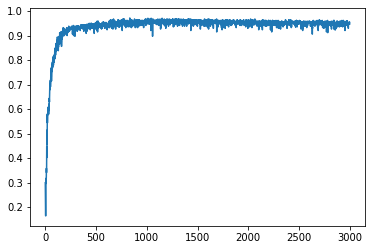

In [15]:
plt.plot(history.history['val_accuracy'])
print(max(history.history['val_accuracy'])

In [16]:
from sklearn.metrics import confusion_matrix

[[52  1  0  0  0  0  4  0  0]
 [ 0 49  0  0  0  0  0  0  0]
 [ 0  0 26  2  0  0  3  0  0]
 [ 0  0  1 34  0  0  0  0  0]
 [ 0  0  3  0 46  0  1  0  0]
 [ 0  0  0  0  0 20  0  0  0]
 [ 1  0  2  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0  0 28]]


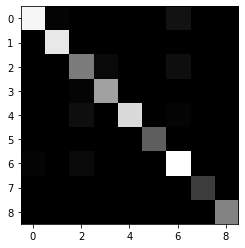

In [17]:
y_pred = model.predict(X_test)
y_p = [np.argmax(yy) for yy in y_pred]
y_tp = [np.argmax(yy) for yy in y_test]
plt.imshow(confusion_matrix(y_tp, y_p), 'gray')
print(confusion_matrix(y_tp, y_p))

In [18]:
with open('./Checkpoints/Model/fruit_classify_der_resnet.json', 'w') as model_write:
    model_write.write(model.to_json())
model.save('./Checkpoints/Weight/fruit_classify_der_resnet.h5')